## 1. Setup

In [6]:
import sys
sys.path.append('..')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

from src import utils, evaluate

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.0


## 2. Load Trained Model

In [7]:
# Choose which model to load
MODEL_PATH = "../best_scratch_ckpt.keras"  # Best model
# MODEL_PATH = "../outputs/models/quickdraw_scratch_final.keras"  # Final model

if not os.path.exists(MODEL_PATH):
    print(f"[ERROR] Model not found: {MODEL_PATH}")
    print("Please train the model first using notebooks/train_model.ipynb")
else:
    model = keras.models.load_model(MODEL_PATH)
    print(f"[INFO] Model loaded from {MODEL_PATH}")
    
    # Get model info
    print(f"\nModel Summary:")
    model.summary()

[INFO] Model loaded from ../best_scratch_ckpt.keras

Model Summary:
Model: "quickdraw_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                   

## 3. Configuration

In [8]:
# Load configuration
config = utils.load_config('../config/config.yaml')

# Dataset paths
ORIGINAL_DATA_DIR = "../quickdraw_images_dedup"  # Your original full dataset
IMG_SIZE = tuple(config['image']['size'])
BATCH_SIZE = 128

# Get class names from the model or config
class_names = sorted([d for d in os.listdir(ORIGINAL_DATA_DIR) 
                     if os.path.isdir(os.path.join(ORIGINAL_DATA_DIR, d))])

print(f"[INFO] Will test on {len(class_names)} classes")
print(f"[INFO] Classes: {class_names}")

[INFO] Configuration loaded from ../config/config.yaml
[INFO] Will test on 26 classes
[INFO] Classes: ['angel', 'apple', 'bat', 'book', 'candle', 'castle', 'cat', 'cup', 'dog', 'door', 'fish', 'flamingo', 'hexagon', 'lantern', 'light bulb', 'mailbox', 'necklace', 'octopus', 'parachute', 'pencil', 'pig', 'skull', 'swan', 'sword', 'table', 'van']


## 4. Load Original Dataset for Testing

In [9]:
# Count images in original dataset
class_counts, total_images = utils.count_images(ORIGINAL_DATA_DIR)
utils.print_dataset_info(class_counts, "Original Full Dataset")


Original Full Dataset Statistics
  Number of classes: 26
  Total images: 130,000
  Average per class: 5000.0
  Min per class: 5,000
  Max per class: 5,000



In [10]:
# Option 1: Load ALL images from original dataset
print("[INFO] Loading full original dataset...")

test_dataset = keras.utils.image_dataset_from_directory(
    ORIGINAL_DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Preprocess (normalize)
def preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

test_dataset = test_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)

num_batches = int(tf.data.experimental.cardinality(test_dataset).numpy())
print(f"[INFO] Dataset loaded: {num_batches} batches")

[INFO] Loading full original dataset...
Found 130000 files belonging to 26 classes.
[INFO] Dataset loaded: 1016 batches


## 5. Alternative: Test on Subset of Original Dataset

In [11]:
# Option 2: Test on a random subset (faster)
# Uncomment this section if you want to test on a subset

"""
SUBSET_SIZE_PER_CLASS = 500  # Test on 500 images per class

print(f"[INFO] Creating subset with {SUBSET_SIZE_PER_CLASS} images per class...")

# Create temporary subset directory
import shutil
import random

SUBSET_DIR = "../data/test_subset"
if os.path.exists(SUBSET_DIR):
    shutil.rmtree(SUBSET_DIR)
os.makedirs(SUBSET_DIR)

for cls in class_names:
    src_dir = os.path.join(ORIGINAL_DATA_DIR, cls)
    dst_dir = os.path.join(SUBSET_DIR, cls)
    os.makedirs(dst_dir, exist_ok=True)
    
    # Get all images
    images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Sample subset
    subset = random.sample(images, min(SUBSET_SIZE_PER_CLASS, len(images)))
    
    # Copy to subset dir
    for img in subset:
        shutil.copy2(os.path.join(src_dir, img), os.path.join(dst_dir, img))

# Load subset
test_dataset = keras.utils.image_dataset_from_directory(
    SUBSET_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

test_dataset = test_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)
print(f"[INFO] Subset dataset created and loaded")
"""

'\nSUBSET_SIZE_PER_CLASS = 500  # Test on 500 images per class\n\nprint(f"[INFO] Creating subset with {SUBSET_SIZE_PER_CLASS} images per class...")\n\n# Create temporary subset directory\nimport shutil\nimport random\n\nSUBSET_DIR = "../data/test_subset"\nif os.path.exists(SUBSET_DIR):\n    shutil.rmtree(SUBSET_DIR)\nos.makedirs(SUBSET_DIR)\n\nfor cls in class_names:\n    src_dir = os.path.join(ORIGINAL_DATA_DIR, cls)\n    dst_dir = os.path.join(SUBSET_DIR, cls)\n    os.makedirs(dst_dir, exist_ok=True)\n    \n    # Get all images\n    images = [f for f in os.listdir(src_dir) if f.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\'))]\n    \n    # Sample subset\n    subset = random.sample(images, min(SUBSET_SIZE_PER_CLASS, len(images)))\n    \n    # Copy to subset dir\n    for img in subset:\n        shutil.copy2(os.path.join(src_dir, img), os.path.join(dst_dir, img))\n\n# Load subset\ntest_dataset = keras.utils.image_dataset_from_directory(\n    SUBSET_DIR,\n    labels=\'inferred\',\n    l

## 6. Evaluate Model on Test Dataset

In [12]:
# Basic evaluation
print("[INFO] Evaluating model...\n")
results = model.evaluate(test_dataset, verbose=1, return_dict=True)

print(f"\n{'='*70}")
print("EVALUATION RESULTS ON ORIGINAL DATASET")
print(f"{'='*70}")
for name, value in results.items():
    print(f"  {name:20s}: {value:.4f}")
print(f"{'='*70}\n")

[INFO] Evaluating model...

1016/1016 [==============================] - 156s 143ms/step - loss: 1.1585 - accuracy: 0.7860 - top3_acc: 0.9287

EVALUATION RESULTS ON ORIGINAL DATASET
  loss                : 1.1585
  accuracy            : 0.7860
  top3_acc            : 0.9287



## 7. Detailed Analysis - Confusion Matrix

In [13]:
# Get predictions
print("[INFO] Generating predictions for detailed analysis...")
y_true, y_pred, y_prob = evaluate.get_predictions(model, test_dataset)

print(f"[INFO] Generated predictions for {len(y_true):,} images")

[INFO] Generating predictions for detailed analysis...
[INFO] Generated predictions for 130,000 images


[INFO] Confusion matrix saved to ../outputs/plots/test_confusion_matrix.png


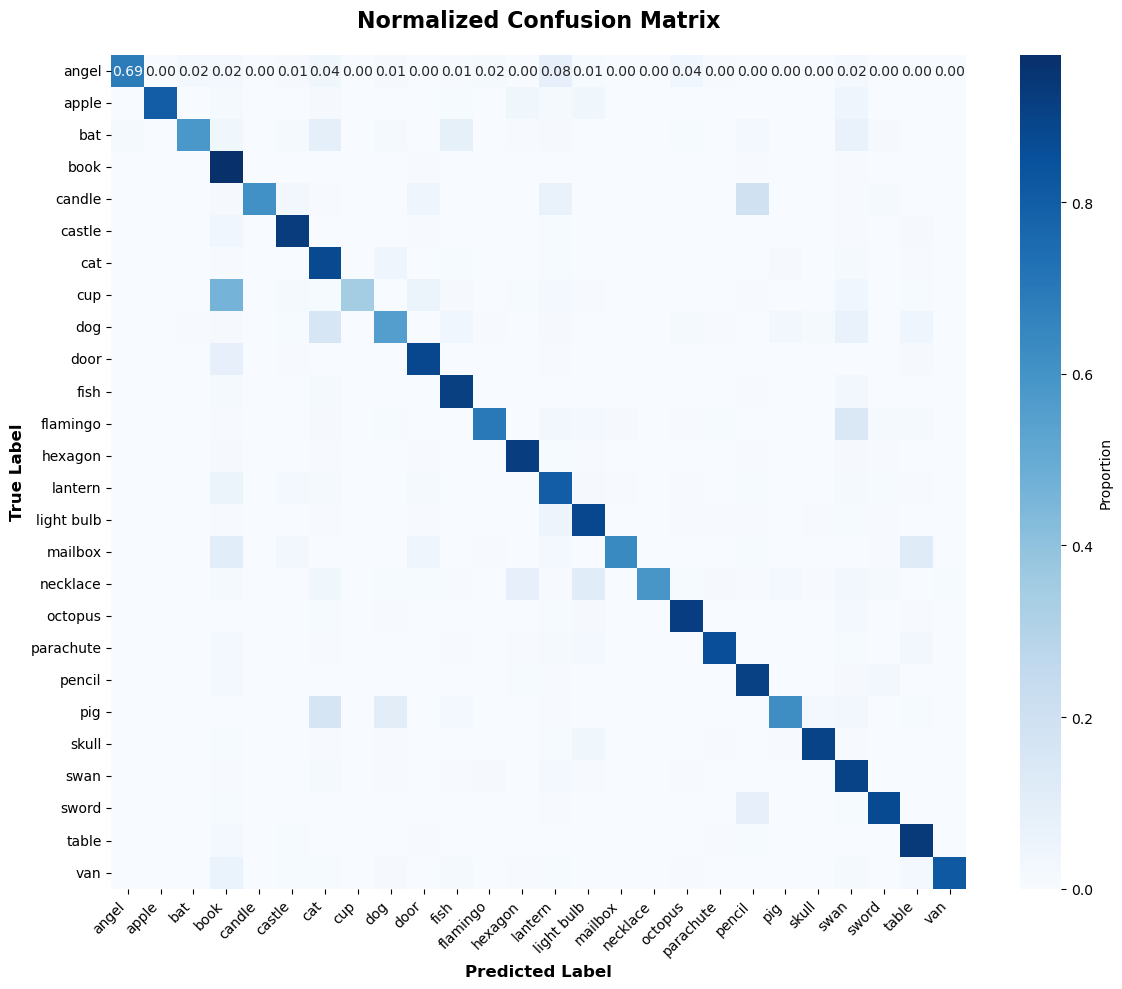

In [14]:
# Plot confusion matrix
evaluate.plot_confusion_matrix(
    y_true, y_pred, class_names,
    save_path="../outputs/plots/test_confusion_matrix.png",
    normalize=True
)

## 8. Per-Class Accuracy

[INFO] Per-class accuracy plot saved to ../outputs/plots/test_per_class_accuracy.png


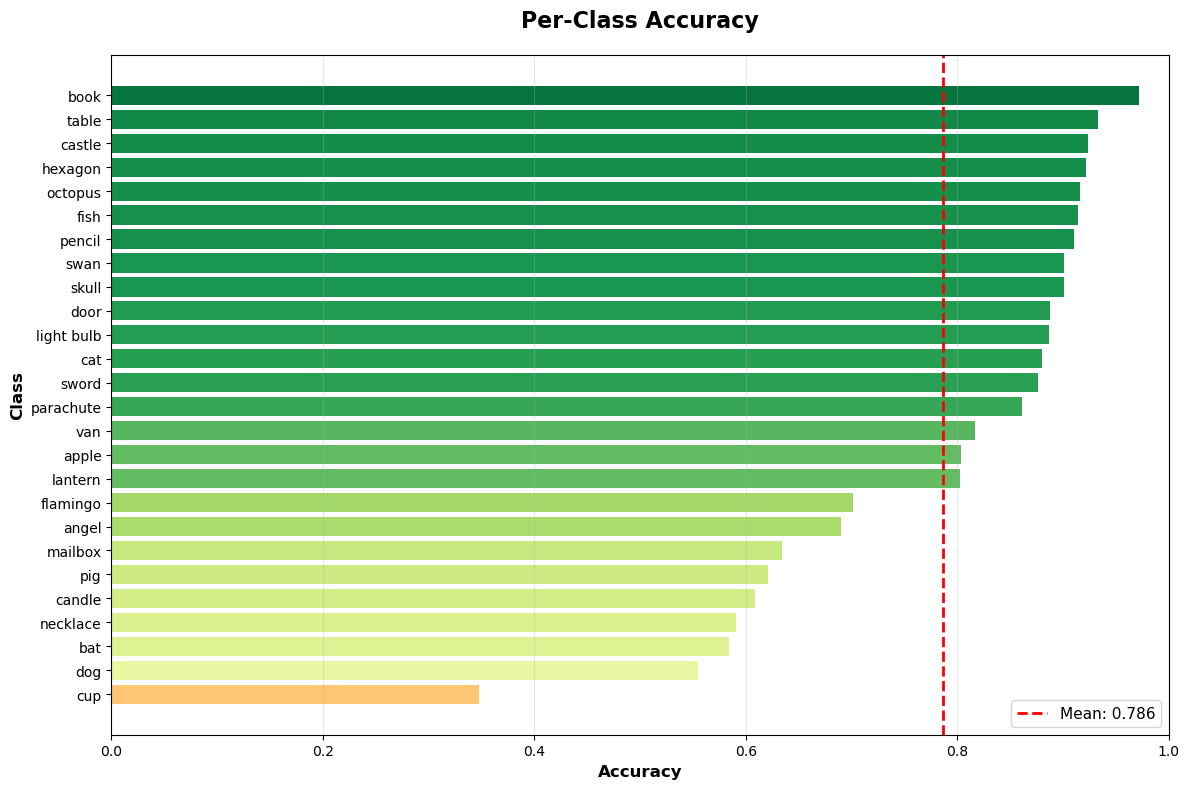

In [15]:
# Plot per-class accuracy
evaluate.plot_per_class_accuracy(
    y_true, y_pred, class_names,
    save_path="../outputs/plots/test_per_class_accuracy.png"
)

## 9. Classification Report

In [16]:
# Print detailed classification report
evaluate.print_classification_report(
    y_true, y_pred, class_names,
    save_path="../outputs/logs/test_classification_report.txt"
)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angel     0.9642    0.6900    0.8044      5000
       apple     0.9973    0.8038    0.8901      5000
         bat     0.9214    0.5838    0.7147      5000
        book     0.4773    0.9720    0.6402      5000
      candle     0.9861    0.6084    0.7525      5000
      castle     0.8285    0.9236    0.8735      5000
         cat     0.5770    0.8798    0.6969      5000
         cup     0.9748    0.3476    0.5125      5000
         dog     0.6946    0.5544    0.6166      5000
        door     0.8021    0.8876    0.8427      5000
        fish     0.8005    0.9140    0.8535      5000
    flamingo     0.9156    0.7012    0.7942      5000
     hexagon     0.8307    0.9214    0.8737      5000
     lantern     0.6368    0.8024    0.7101      5000
  light bulb     0.7427    0.8866    0.8083      5000
     mailbox     0.9468    0.6342    0.7596      5000
    necklace     0.9801    0.5904    0.7369      5000
    

## 10. Most Common Errors

[INFO] Top errors plot saved to ../outputs/plots/test_top_errors.png


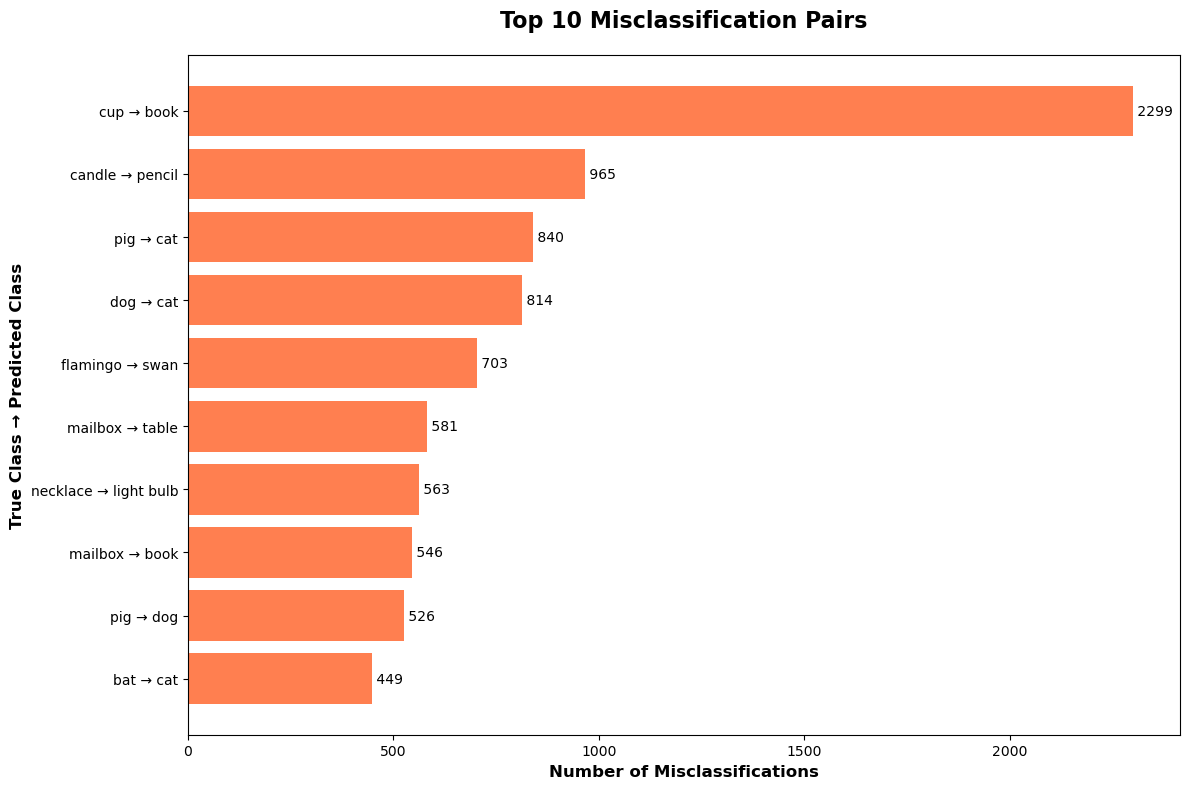

In [17]:
# Plot top misclassification pairs
evaluate.plot_top_errors(
    y_true, y_pred, class_names,
    top_n=10,
    save_path="../outputs/plots/test_top_errors.png"
)

## 11. Sample Predictions Visualization

In [ ]:
# Visualize sample predictions
evaluate.visualize_predictions(
    model, test_dataset, class_names,
    samples_per_class=5,
    save_path="../outputs/plots/test_sample_predictions.png"
)

## 12. Test on Single Image

In [ ]:
# Test on a single image file
def predict_single_image(image_path, model, class_names, img_size=(128, 128)):
    """
    Predict class for a single image
    
    Args:
        image_path: Path to image file
        model: Trained model
        class_names: List of class names
        img_size: Target image size
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Get top 5 predictions
    top_5_idx = np.argsort(predictions)[-5:][::-1]
    
    # Display
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show image
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title(f'Input Image', fontsize=14, fontweight='bold')
    
    # Show predictions
    top_5_names = [class_names[i] for i in top_5_idx]
    top_5_probs = [predictions[i] for i in top_5_idx]
    
    colors = ['green' if i == 0 else 'skyblue' for i in range(5)]
    axes[1].barh(range(5), top_5_probs, color=colors)
    axes[1].set_yticks(range(5))
    axes[1].set_yticklabels(top_5_names)
    axes[1].set_xlabel('Confidence', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].invert_yaxis()
    
    # Add percentage labels
    for i, (name, prob) in enumerate(zip(top_5_names, top_5_probs)):
        axes[1].text(prob + 0.02, i, f'{prob*100:.1f}%', 
                    va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\nTop Prediction: {top_5_names[0]} ({top_5_probs[0]*100:.2f}%)")
    print("\nTop 5 Predictions:")
    for i, (name, prob) in enumerate(zip(top_5_names, top_5_probs), 1):
        print(f"  {i}. {name:15s} - {prob*100:.2f}%")


# Example usage:
# Uncomment and modify the path to test on a specific image

"""
IMAGE_PATH = "../quickdraw_images_dedup/cat/image_001.png"
predict_single_image(IMAGE_PATH, model, class_names, IMG_SIZE)
"""

print("[INFO] Use predict_single_image(path, model, class_names, IMG_SIZE) to test individual images")

## 13. Test on Random Samples from Each Class

In [ ]:
# Pick random images from each class and predict
import random

num_samples = 3

print(f"\n{'='*70}")
print(f"Testing {num_samples} random samples from each class")
print(f"{'='*70}\n")

for cls in class_names:
    class_dir = os.path.join(ORIGINAL_DATA_DIR, cls)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Sample random images
    samples = random.sample(images, min(num_samples, len(images)))
    
    correct = 0
    for img_name in samples:
        img_path = os.path.join(class_dir, img_name)
        
        # Load and predict
        img = Image.open(img_path).convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        pred = model.predict(img_array, verbose=0)[0]
        pred_class = class_names[np.argmax(pred)]
        confidence = np.max(pred)
        
        if pred_class == cls:
            correct += 1
    
    accuracy = correct / len(samples) * 100
    print(f"{cls:20s}: {correct}/{len(samples)} correct ({accuracy:.1f}%)")

print(f"\n{'='*70}")

## 14. Summary

In [ ]:
# Print final summary
print(f"\n{'='*70}")
print("TEST SUMMARY")
print(f"{'='*70}")
print(f"  Model: {MODEL_PATH}")
print(f"  Test Dataset: {ORIGINAL_DATA_DIR}")
print(f"  Total Images: {len(y_true):,}")
print(f"  Number of Classes: {len(class_names)}")
print(f"\n  Overall Accuracy: {results['accuracy']*100:.2f}%")
if 'top3_acc' in results:
    print(f"  Top-3 Accuracy: {results['top3_acc']*100:.2f}%")
print(f"\n  All results saved to outputs/ directory")
print(f"{'='*70}\n")